# Variational Inference with Normalizing Flows
[Paper Link](https://arxiv.org/abs/1505.05770#:~:text=Our%20approximations%20are%20distributions%20constructed,level%20of%20complexity%20is%20attained.)

# TO-DO
* Compare to https://towardsdatascience.com/variational-inference-with-normalizing-flows-on-mnist-9258bbcf8810

## Import moduels 

In [1]:
import os 
import numpy as np 
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

## Load data 

In [2]:
(X_train, _), (X_test, _) = keras.datasets.mnist.load_data()

# Scale data 
X_train, X_test = X_train/255, X_test/255

# Flatten data 
X_train, X_test = X_train.reshape(60000,784), X_test.reshape(10000,784)

print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))

X_train shape: (60000, 784)
X_test shape: (10000, 784)


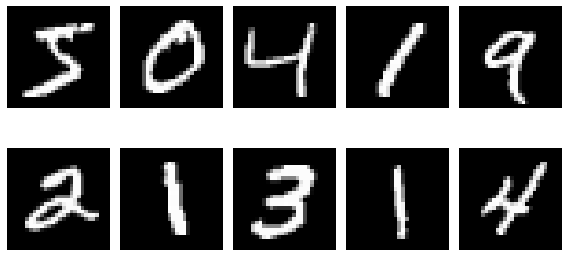

In [3]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 5
rows = 2
j = 0
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i).set_axis_off()
    plt.imshow(X_train[j,:].reshape(28,28),cmap='gray')
    plt.tight_layout()
    j += 1
plt.tight_layout()
plt.show()

## Model 

### Planar Flows
$ f(z) = z + u h(w^Tz + b) $

In [4]:
class PlanarFlow(layers.Layer):
    def __init__(self,input_dim,activation = 'tanh'):
        super().__init__()
        self.input_dim = input_dim
        self.activation, self.deriv_activation = self.getActivation(activation)

    def getActivation(self,activation):
        if activation == 'elu':
            f = tf.nn.elu
            df = lambda x: tf.ones_like(x,dtype=tf.float32)* tf.cast((x >= 0),tf.float32)\
                                        + tf.math.exp(x) * tf.cast((x < 0),tf.float32)
            return f, df
        elif activation == 'tanh':
            f = tf.math.tanh
            df = lambda x: 1-tf.math.tanh(x)**2
            return f, df

    def build(self,input_dim):
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value=w_init(shape=(1,self.input_dim), dtype="float32"),
            trainable=True,
        )
        
        u_init = tf.random_normal_initializer()
        self.u = tf.Variable(
            initial_value=u_init(shape=(1,self.input_dim), dtype="float32"),
            trainable=True,
        )
        
        b_init = tf.random_normal_initializer()
        self.b = tf.Variable(
            initial_value=b_init(shape=(1,1), dtype="float32"), trainable=True
        )        

    def call(self,z):
        lin = tf.matmul(z,tf.transpose(self.w)) +self.b
        f = z + self.u*self.activation(lin)
        
        # WORKING HERE
        #test = self.deriv_activation(lin)
        #print(test)
        
        phi = self.deriv_activation(lin)*self.w
        
        log_det = tf.math.log(tf.math.abs(1+tf.matmul(phi,tf.transpose(self.u)) ))
        return phi, log_det

### Radial Flows
$ f(z) = z + \beta h (\alpha , r )(z - z_0 ) $

In [5]:
class RadialFlow(layers.Layer):
    def __init__(self,input_dim,activation = 'tanh'):
        super().__init__()
        self.input_dim = input_dim
        self.activation, self.deriv_activation = self.getActivation(activation)

    def getActivation(self,activation):
        if activation == 'elu':
            f = tf.nn.elu
            df = lambda x: tf.ones_like(x,dtype=tf.float32)* tf.cast((x >= 0),tf.float32)\
                                        + tf.math.exp(x) * tf.cast((x < 0),tf.float32)
            return f, df
        elif activation == 'tanh':
            f = tf.math.tanh
            df = lambda x: 1-tf.math.tanh(x)**2
            return f, df

    def build(self,input_dim):
        z0_init = tf.random_normal_initializer()
        self.z0 = tf.Variable(
            initial_value=z0_init(shape=(1,self.input_dim), dtype="float32"),
            trainable=True,
        )
        
        log_alpha_init = tf.random_normal_initializer()
        self.log_alpha = tf.Variable(
            initial_value=log_alpha_init(shape=(1,1), dtype="float32"), trainable=True
        )     
        
        beta_init = tf.random_normal_initializer()
        self.beta = tf.Variable(
            initial_value=beta_init(shape=(1,1), dtype="float32"), trainable=True
        )        

    def call(self,z):
        z_sub = z-self.z0
        alpha = tf.math.exp(self.log_alpha)
        r = tf.norm(z_sub,axis=1)
        h = tf.transpose(1 / (alpha + r))
        f = z + self.beta * h * z_sub
        
        log_det = (self.input_dim-1)*tf.math.log(1+self.beta*h)+tf.math.log(1+self.beta*h\
                                          +self.beta - tf.transpose(self.beta*r/(alpha+r)**2))
        return f, log_det


### VAE_Flow

In [6]:
class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.math.exp(log_var+1e-6) + mean

class VaeFlow(keras.Model):
    def __init__(self,input_dim,codings_size,n_flow_steps,flow_type='planar',**kwargs):
        super(VaeFlow, self).__init__(**kwargs)
        self.EPS = 1e-6
        self.input_dim = input_dim 
        
        # Flow parameters 
        self.codings_size = codings_size
        self.n_flow_steps = n_flow_steps 
        if flow_type == 'planar':
            self.flow_type = PlanarFlow
        elif flow_type == 'radial':
            self.flow_type = RadialFlow
        
        # Model parts
        self.encoder = self.getEncoder()
        self.flow_steps = [self.flow_type(self.codings_size,'elu') for i in range(self.n_flow_steps)]
        self.decoder = self.getDecoder()
        
        # Loss functions 
        self.bce = tf.keras.losses.BinaryCrossentropy()
        self.loss_tracker = keras.metrics.Mean(name="loss")
        
    @property
    def metrics(self):
        """List of the model's metrics.
        We make sure the loss tracker is listed as part of `model.metrics`
        so that `fit()` and `evaluate()` are able to `reset()` the loss tracker
        at the start of each epoch and at the start of an `evaluate()` call.
        """
        return [self.loss_tracker]
        
    def getEncoder(self):
        inputs = keras.layers.Input(shape=(self.input_dim))
        x = layers.Dense(int(self.input_dim/1.5),activation="selu")(inputs)
        x = layers.Dense(int(self.input_dim/2),activation="selu")(x)
        x = layers.Dense(int(self.input_dim/3),activation="selu")(x)        
        codings_mean = keras.layers.Dense(self.codings_size)(x)
        codings_log_var = keras.layers.Dense(self.codings_size,activation="softplus")(x)
        codings = Sampling()([codings_mean, codings_log_var])
        encoder = keras.models.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])
        return encoder

    def getDecoder(self):
        inputs = keras.layers.Input(shape=[self.codings_size])
        x = layers.Dense(int(self.input_dim/3),activation="selu")(inputs)
        x = layers.Dense(int(self.input_dim/2),activation="selu")(x)
        x = layers.Dense(int(self.input_dim/1.5),activation="selu")(x)  
        x = keras.layers.Dense(self.input_dim, activation="sigmoid")(x)
        decoder = keras.models.Model(inputs=[inputs], outputs=[x])
        return decoder
    
    def mleNormal(self,z,mean,var):
        alpha = -.5*tf.math.log(2*np.pi)-.5*tf.math.log(var+self.EPS)-.5* tf.math.pow(((z-mean)/var),2)
        loss = tf.math.reduce_sum(alpha,axis=-1)
        return loss
    
    def mleStandardNormal(self,z):
        alpha = -.5*tf.math.log(2*np.pi)+tf.math.pow(z,2)
        loss = tf.math.reduce_sum(alpha,axis=-1)
        return loss
            
    def reconLoss(self,X,xh):
        recon_loss = self.bce(X,xh)
        return recon_loss

    def train_step(self, data):
        X, _ = data
        log_det = 0
        
        with tf.GradientTape() as tape:
            # Pass through encoder
            z_mean, z_var, z = self.encoder(X)
            z0 = tf.identity(z)
            
            # Pass through flow steps 
            for step in self.flow_steps:
                z, log_det_step = step(z)
                #print(z,log_det)
                log_det += log_det_step
            
            # Pass through decoder
            xh = self.decoder(z)
            
            # MLE of z0~prior normal 
            latent_mle = self.mleNormal(z0,z_mean,z_var)
            
            # MLE of zK~flow output
            flow_mle = self.mleStandardNormal(z)
            
            # Reconstruction loss
            recon_loss = self.reconLoss(X,xh) 

            # Total loss
            loss = -1*tf.math.reduce_mean(latent_mle-recon_loss-flow_mle-log_det,axis=-1)
            #print(latent_mle,flow_mle,recon_loss,log_det)
        
            self.loss_tracker.update_state(loss)
            
        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        return {
            "loss": self.loss_tracker.result(),
        }
    
    def test_step(self, data):
        X, _ = data
        log_det = 0
    
        # Pass through encoder
        z_mean, z_var, z = self.encoder(X)
        z0 = tf.identity(z)
            
        # Pass through flow steps 
        for step in self.flow_steps:
            z, log_det_step = step(z)
            log_det += log_det_step
            
        # Pass through decoder
        xh = self.decoder(z)
            
        # MLE of z0~prior normal 
        latent_mle = self.mleNormal(z0,z_mean,z_var)
            
        # MLE of zK~flow output
        flow_mle = self.mleStandardNormal(z)
            
        # Reconstruction loss
        recon_loss = self.reconLoss(X,xh) 

        # Total loss
        #print(latent_mle,flow_mle,recon_loss,log_det)
        
        loss = -1*tf.math.reduce_mean(latent_mle-recon_loss-flow_mle-log_det,axis=-1)
        self.loss_tracker.update_state(loss)

        return {
            "loss": self.loss_tracker.result(),
        }
    
    def interpolate(self, A, B):
        # Pass through encoder
        A_mean, A_var, a  = self.encoder(A)
        B_mean, B_var, b  = self.encoder(B)
        
        # Mix encoder output 
        beta_values = np.random.beta(.5,.5,(a.get_shape()[-1]))
        z = a*beta_values+(1-beta_values)*b
        
        # Pass through flow steps 
        for step in self.flow_steps:
            z, _ = step(z)

        # Pass through decoder
        xh = self.decoder(z)
        return xh
    
    def sample(self,mean=0,stddev=1):
        z = tf.random.normal(shape=[1, self.codings_size],mean=mean, stddev=stddev)
            
        # Pass through flow steps 
        for step in self.flow_steps:
            z, _ = step(z)

        # Pass through decoder
        xh = self.decoder(z)
        return xh

## Fit model 

In [7]:
INPUT_DIM = 784
CODING_SIZE = 120
N_FLOW_STEPS = 10

In [8]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)

model = VaeFlow(INPUT_DIM,CODING_SIZE,N_FLOW_STEPS)
#model.compile(optimizer=opt,run_eagerly=True)
model.compile(optimizer=opt)

In [9]:
history = model.fit(X_test, X_test, epochs=30, batch_size=32)

Epoch 1/30
313/313 [==============================] - 5s 8ms/step - loss: 466.1147
Epoch 2/30
313/313 [==============================] - 3s 8ms/step - loss: 419.1159
Epoch 3/30
313/313 [==============================] - 3s 9ms/step - loss: 402.7565
Epoch 4/30
313/313 [==============================] - 3s 10ms/step - loss: 403.3811
Epoch 5/30
313/313 [==============================] - 3s 9ms/step - loss: 404.9448
Epoch 6/30
313/313 [==============================] - 4s 11ms/step - loss: 406.3509
Epoch 7/30
313/313 [==============================] - 5s 14ms/step - loss: 407.0277
Epoch 8/30
313/313 [==============================] - 4s 14ms/step - loss: 409.8251
Epoch 9/30
313/313 [==============================] - 4s 12ms/step - loss: 406.3799
Epoch 10/30
313/313 [==============================] - 3s 10ms/step - loss: 406.1199
Epoch 11/30
313/313 [==============================] - 4s 13ms/step - loss: 407.5295
Epoch 12/30
313/313 [==============================] - 4s 12ms/step - loss: 40

## Sample model 

### Interpolate

In [10]:
A, B  = X_train[0,:], X_train[1,:]

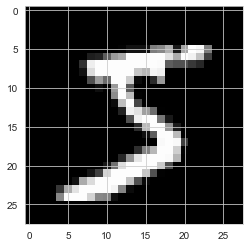

In [11]:
plt.imshow(A.reshape(28,28),cmap='gray')

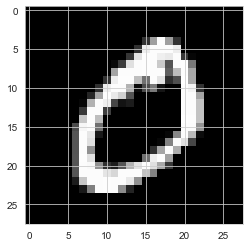

In [12]:
plt.imshow(B.reshape(28,28),cmap='gray')

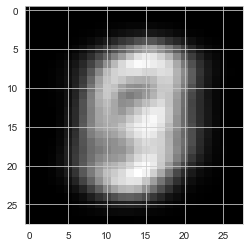

In [13]:
mix_A_B = model.interpolate(A[np.newaxis,...],B[np.newaxis,...]).numpy()
plt.imshow(mix_A_B.reshape(28,28),cmap='gray')

### Random sample 

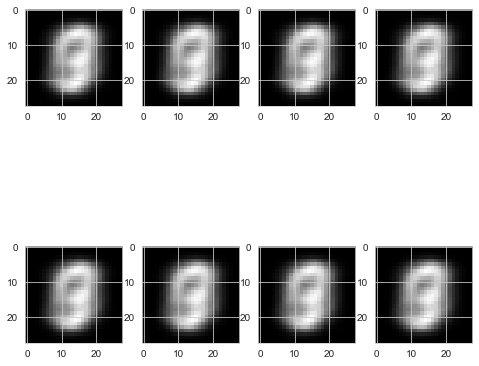

In [24]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 2
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    img = model.sample(10,.1).numpy()
    plt.imshow(img.reshape(28,28), cmap="gray")
plt.show()